# Building a dark frame

A dark frame is an image taken without illuminating the sensor (in the dark). The signal in a light (as opposed to dark) image is the sum of the light signal (from the observed scene) and the dark signal. The first step when processing a light image is to subtract the *mean* dark signal.
In an individual dark frame, the values are the sum of the [bias](bias.ipynb), of the thermal signal and of the read noise. The per-pixel bias can be determined by averaging a large number of zero-second exposure dark frames. The read noise has zero mean and its standard deviation can be measured using [ptc analysis](ptc.ipynb). The thermal signal is a function of the temperature of the sensor and is proportional to the exposure time. The thermal electrons are indistinguishable from photo-electrons. For a given pixel, its value fluctuates according to Poisson statistics from frame to frame. For a given mean in a single frame, its value fluctuates from pixel to pixel.

One should not use a single dark frame to calibrate a light frame, for otherwise the random fluctuations of the thermal signal and read noise would be added to the result.
One must thus estimate the *mean* dark signal from a large number of acquisitions made at the exposure time and temperature chosen for the light images.

# Data acquisition

We will operate at gain setting 100, as justified by analyzing the [noise in a stack of images](exposure.ipynb). For gain 100, we determined that the [optimal bias](bias.ipynb) is 15.
We will need dark frames at 0 seconds (to produce the [flat fields](flats.ipynb)), 30s for regular exposures [noise in a stack of images](exposure.ipynb) and 90s for long exposures (not sure to use them).
For each exposure time, take 100 images at gain 100 and bias 15, and store them in three different directories.


100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


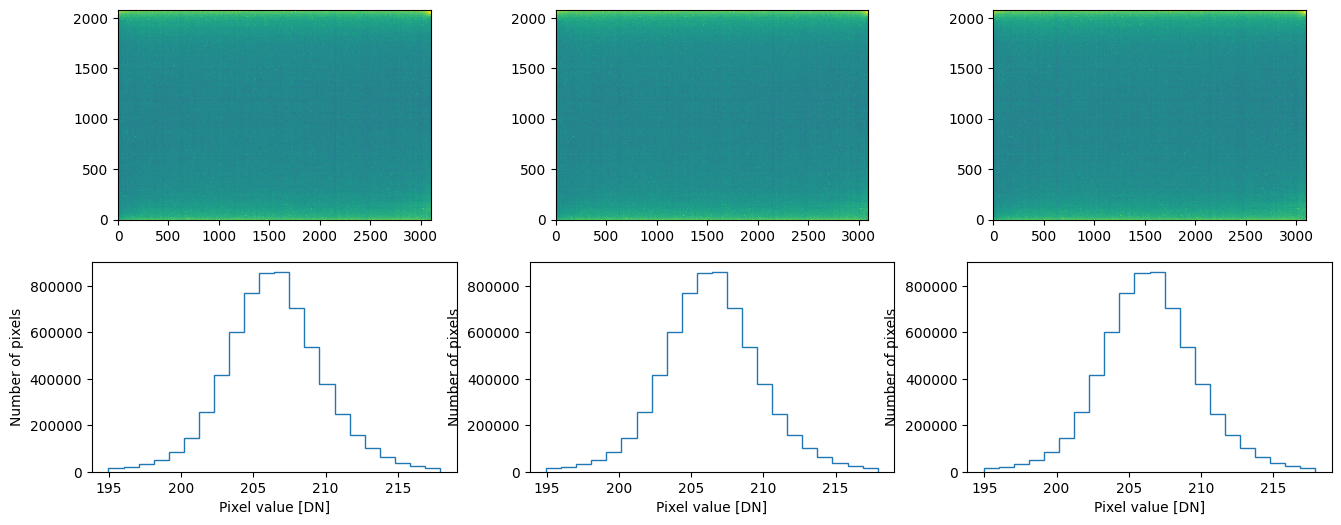

In [7]:
import os
from tqdm import tqdm
import glob
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, PercentileInterval
import matplotlib.pyplot as plt

import inout

# Replace by your directories
paths = [r'C:\Users\fauchere\Pictures\ZWO ASI178MM-Cool\2023-07-12\DARK_2.00',
         r'C:\Users\fauchere\Pictures\ZWO ASI178MM-Cool\2023-07-12\DARK_2.00',
         r'C:\Users\fauchere\Pictures\ZWO ASI178MM-Cool\2023-07-12\DARK_2.00']

fix, axes = plt.subplots(2, 3, figsize=(16, 6))

dark_frames = []  # used to save the stacked dark frames
base_headers = []  # used to save one header for later
for i, path in enumerate(paths):
        files = glob.glob(os.path.join(path, '*.fits'))

        # Averages the dark frames
        dark_frame = 0
        for f in tqdm(files):
            dark_frame = dark_frame + fits.getdata(f)
        dark_frame = dark_frame / len(files)

        dark_frames.append(dark_frame)
        base_headers.append(fits.get_header(files[0]))

        norm = ImageNormalize(dark_frame, stretch=LinearStretch(), interval=PercentileInterval(99))

        axes[0, i].imshow(dark_frame, norm=norm, origin='lower')
        axes[1, i].hist(dark_frame.flatten(), histtype='step', bins=int(norm.vmax - norm.vmin), range=[norm.vmin, norm.vmax])
        axes[1, i].set_xlabel('Pixel value [DN]')
        axes[1, i].set_ylabel('Number of pixels')

The ASI 2600 has a vary uniform dark signal. Other sensors can show significantly non uniform patterns, *e.g.* [hotter (thus brighter) edges / corners](https://www.cloudynights.com/uploads/monthly_01_2016/post-199816-0-67542700-1452139850.jpg).

We now save the averaged dark frames with a basic header.

In [2]:
camera = 'ASI2600MM'

for base_header, dark_frame in zip(base_headers, dark_frames):

        gain = base_header['GAIN']
        temp = base_header['CCD-TEMP']
        date = base_header['DATE-OBS']

        keys = (
                ('DATE-OBS', date),
                ('INSTRUME', camera),
                ('OFFSET', base_header['OFFSET']),
                ('ISO', gain),
                ('EXPTIME', base_header['EXPTIME']),
                ('NBIMGS', int(len(files))),
                ('TEMP', temp),
                ('AVGTEMP', temp)
        )

        # change to whatever directory you want ot store the stacked darks into
        inout.save_calibration_frame(rf'C:\EOS6D\bias\asi178mm_bias_iso00{gain}_t{temp:.3f}_{date[0:10]}.fits', dark_frame, keys)
